In [1]:
import warnings
warnings.filterwarnings("ignore")
import os,logging
logging.disable(logging.WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
# Workspace problem with several narrow gaps
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import os
import csv
from random import randint, random
import time
import pathlib
# import cv2
config = tf.ConfigProto()
config.gpu_options.allow_growth=True

In [3]:
tf.test.is_gpu_available()

True

# Clarification
Due to the loading of the array in MATLAB is transposed, column wise and not row wise, the data generated is of the format ```(y_sample,x_sample,y_init,x_init)```
Therefore the needful must be done to properly visualise the sampled points.

In [4]:
# STATE_DIM = 2  # state dimension x, y
# VALS_PER_SAMPLE = 6  # number of numbers per training sample
# SAMPLE_SCALE_UP = 160
# MAP_NUM = 5  # which map training on
# DATA_ROOT = './Training_Data'
# MODEL_DIR = './Models/0'+str(MAP_NUM)
# # Parse sampling data
# samples_file = os.path.join(DATA_ROOT, 'nodes_{}.txt'.format(MAP_NUM))
# with open(samples_file, 'r') as f:
#   txt_rows = f.read().split("\n")
#   data_list = []
#   for row in txt_rows:
#     new_data = []
#     for val in row.split(" "):
#       try:
#         num = float(val)
#         new_data.append(num)
#       except ValueError:
#         continue
#     if len(new_data) == VALS_PER_SAMPLE:
#       data_list.append(new_data)
#     else:
#       print("Error parsing a line: %s" % row)
# sample_data = np.array(data_list,dtype='float')

# # Load original map that was sampled from
# orig_map_file = os.path.join(DATA_ROOT, 'map{}.npy'.format(MAP_NUM))
# orig_map = np.load(orig_map_file)

# # Parse mini map that was sampled from for training
# mini_map_file = os.path.join(DATA_ROOT, 'map{}_mini.npy'.format(MAP_NUM))
# map_data = np.load(mini_map_file)
# print("Done!")




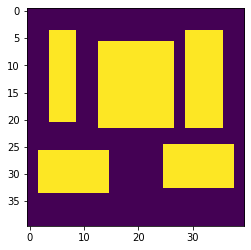

In [5]:
# NOTE: State Format is (ROW, COL, THETA): [sy, sx, st, iy, ix, iz, gy, gx, gt]!!!!!!!!
STATE_DIM = 3  # state dimension x, y, theta
VALS_PER_SAMPLE = 3 * STATE_DIM  # (sample, init, goal) * STATE_DIM
SAMPLE_SCALE_UP = 160
DATA_ROOT = './Training_Data'
MODEL_DIR = './Models/Unified_1'

# Parse sampling data
train_map_ids = [3,4,5] # [1, 3, 4, 5, 6]
test_map_ids = [2, 7]  # used later for testing
train_maps = dict()
all_orig_maps = dict()
all_data = np.array([], dtype=np.float).reshape(0,VALS_PER_SAMPLE + 40*40)
for map_num in train_map_ids:
  mini_map_file = os.path.join(DATA_ROOT, 'map{}_mini.npy'.format(map_num))
  map_data = np.load(mini_map_file)

  orig_map_file = os.path.join(DATA_ROOT, 'map{}.npy'.format(map_num))
  all_orig_maps[map_num] = np.load(orig_map_file)

  unrolled_map = np.concatenate(map_data, axis=0)
  train_maps[map_num] = unrolled_map
  unrolled_map = unrolled_map.reshape(1,len(unrolled_map))  # 1 x N^2

  plt.imshow(map_data * 255)
  
  samples_file = os.path.join(DATA_ROOT, 'map{}_training.npz'.format(map_num))
  samples_data = np.array(np.load(samples_file)['data'])
  num_samples = samples_data.shape[0]

  # dubplicates unrolleded map from 1xN^2 into MxN^2 where M = num_samples
  # then appends to samples so each sample row has unrolled map
  train_data = np.hstack([samples_data, np.repeat(unrolled_map, num_samples, axis=0)])

  # append to bottom of all_data matrix of size KxN^2
  all_data = np.concatenate([all_data, train_data], axis=0)
  

# shuffle data to not bias by order of maps
np.random.shuffle(all_data)


# Don't load these in case the above step takes up too much RAM
# # Load original map that was sampled from
# orig_map_file = os.path.join(DATA_ROOT, 'map{}.npy'.format(MAP_NUM))
# orig_map = np.load(orig_map_file)

# # Parse mini map that was sampled from for training
# mini_map_file = os.path.join(DATA_ROOT, 'map{}_mini.npy'.format(MAP_NUM))
# map_data = np.load(mini_map_file)
# print("Done!")


In [6]:
all_data.shape

(10815, 1609)

Network Hyperparameters

In [7]:
# # neural network parameters
# mb_size = 256  # mini batch GD size
# h_Q_dim = 512
# h_P_dim = 512
# z_dim = 3 # latent
# c = 0  # 
# lr = 1e-4  # learning rate
# state_weights = [[1, 1]]  # both states (x,y) are equally important
# TRAIN_ITERS = 500000
# ITERS_PER_SAVE = 10000

# # split the inputs and conditions into test train (to be processed in the next step into an occupancy grid representation)
# ratioTestTrain = 0.8
# numEntries = sample_data.shape[0]
# numTrain = int(numEntries*ratioTestTrain)
# numTest = numEntries - numTrain

# # x_train and x_test are the samples from solved paths
# x_train = sample_data[:numTrain, :STATE_DIM] # state: row, col
# x_test = sample_data[numTrain:, :STATE_DIM]  # other part of data

# # cond_data 1D array of concatenated [init, goal, map]
# unrolled_map = np.concatenate(map_data, axis=0)
# COND_DIM = STATE_DIM + STATE_DIM + len(unrolled_map)  # init + goal + map
# cond_data = np.zeros((numEntries, COND_DIM))
# for r in range(numEntries):
#   cond_data[r,:] = np.concatenate([sample_data[r,STATE_DIM:], unrolled_map], axis=0)

# cond_train = cond_data[:numTrain, :]
# cond_test = cond_data[numTrain:, :]

In [8]:
# neural network parameters
mb_size = 256  # mini batch GD size
h_Q_dim = 512
h_P_dim = 512
z_dim = 3 # latent
c = 0  # 
lr = 1e-4  # learning rate
state_weights = [[1, 1, 0.5]]  # both states (x,y, theta) are equally important
assert(len(state_weights[0]) == STATE_DIM)  # cost weight of each state!
TRAIN_ITERS = 1000000
ITERS_PER_SAVE = 10000

# split the inputs and conditions into test train (to be processed in the next step into an occupancy grid representation)
ratioTestTrain = 0.8
numEntries = all_data.shape[0]
numTrain = int(numEntries*ratioTestTrain)
numTest = numEntries - numTrain

# x_train and x_test are the samples from solved paths
x_train = all_data[:numTrain, :STATE_DIM] # state: x, y, theta
x_test = all_data[numTrain:, :STATE_DIM]  # other part of data

# conditional data
COND_DIM = all_data.shape[1] - STATE_DIM  # (init, goal, unrolled_map)
cond_train = all_data[:numTrain, STATE_DIM:]
cond_test = all_data[numTrain:, STATE_DIM:]

In [9]:
# # Load original map that was sampled from and print any collisions
# orig_map_file = os.path.join(DATA_ROOT, 'map{}.npy'.format(5))
# orig_map = np.load(orig_map_file)
# plt.imshow(orig_map)
# plt.scatter(x=x_train[:,1]*SAMPLE_SCALE_UP, y=x_train[:,0]*SAMPLE_SCALE_UP, color="red", s=0.5,) # init
# plt.show()
# x=x_train[:,0]*SAMPLE_SCALE_UP
# y=x_train[:,1]*SAMPLE_SCALE_UP
# for i,j in zip(x_train[:,0],x_train[:,1]):
#   if orig_map[int(i*SAMPLE_SCALE_UP),int(j*SAMPLE_SCALE_UP)]==1:
#     print(i,j)
#     print(i*SAMPLE_SCALE_UP,j*SAMPLE_SCALE_UP)

# Training
To rename output tensors ``` tf.identity(z, name="z")``` 

In [10]:
# define networks
X = tf.placeholder(tf.float32, shape=[None, STATE_DIM], name="X")
c = tf.placeholder(tf.float32, shape=[None, COND_DIM], name="c")

# Q (Encoder)
inputs_Q = tf.concat(axis=1, values=[X,c])

dense_Q1 = tf.layers.dense(inputs=inputs_Q, units=h_Q_dim, activation=tf.nn.relu)
dropout_Q1 = tf.layers.dropout(inputs=dense_Q1, rate=0.5)
dense_Q2 = tf.layers.dense(inputs=dropout_Q1, units=h_Q_dim, activation=tf.nn.relu)

z_mu = tf.layers.dense(inputs=dense_Q2, units=z_dim) # output here is z_mu
z_logvar = tf.layers.dense(inputs=dense_Q2, units=z_dim) # output here is z_logvar

# P (Reparameterisation tricks)
eps = tf.random_normal(shape=tf.shape(z_mu))
z = tf.add(z_mu, tf.exp(z_logvar / 2) * eps)
inputs_P = tf.concat(axis=1, values=[z,c])

# (Decoder)
dense_P1 = tf.layers.dense(inputs=inputs_P, units=h_P_dim, activation=tf.nn.relu)
dropout_P1 = tf.layers.dropout(inputs=dense_P1, rate=0.5)
dense_P2 = tf.layers.dense(inputs=dropout_P1, units=h_P_dim, activation=tf.nn.relu)

y = tf.layers.dense(inputs=dense_P2, units=STATE_DIM) # fix to also output y

# training
recon_loss = tf.losses.mean_squared_error(labels=X, predictions=y, weights=state_weights)
# TODO: fix loss function for angles going around
kl_loss = 10**-4 * 2 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1)

cvae_loss = tf.reduce_mean(kl_loss + recon_loss)

train_step = tf.train.AdamOptimizer(lr).minimize(cvae_loss)

sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())
tf.train.export_meta_graph(MODEL_DIR+'/graph.meta')
it = 0;

Iter: 0
Loss: 0.7999



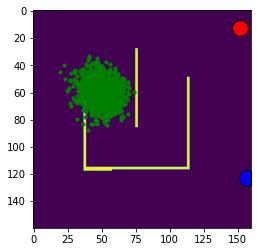

Iter: 1000
Loss: 0.01569

Iter: 2000
Loss: 0.005088

Iter: 3000
Loss: 0.005596

Iter: 4000
Loss: 0.005549

Iter: 5000
Loss: 0.004759

Iter: 6000
Loss: 0.004594

Iter: 7000
Loss: 0.005005

Iter: 8000
Loss: 0.00451

Iter: 9000
Loss: 0.004761

Iter: 10000
Loss: 0.004654



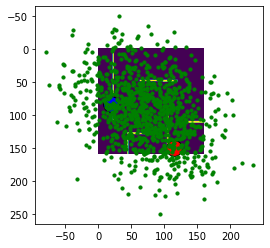

Iter: 11000
Loss: 0.004976

Iter: 12000
Loss: 0.004995

Iter: 13000
Loss: 0.004241

Iter: 14000
Loss: 0.004304

Iter: 15000
Loss: 0.006163

Iter: 16000
Loss: 0.004418

Iter: 17000
Loss: 0.004363

Iter: 18000
Loss: 0.004137

Iter: 19000
Loss: 0.005045

Iter: 20000
Loss: 0.004202



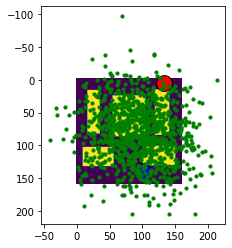

Iter: 21000
Loss: 0.004536

Iter: 22000
Loss: 0.004056

Iter: 23000
Loss: 0.004528

Iter: 24000
Loss: 0.004444

Iter: 25000
Loss: 0.004213

Iter: 26000
Loss: 0.00394

Iter: 27000
Loss: 0.004155

Iter: 28000
Loss: 0.00415

Iter: 29000
Loss: 0.003923

Iter: 30000
Loss: 0.00397



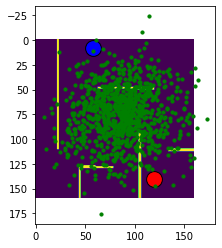

Iter: 31000
Loss: 0.004202

Iter: 32000
Loss: 0.00389

Iter: 33000
Loss: 0.003951

Iter: 34000
Loss: 0.004891

Iter: 35000
Loss: 0.004059

Iter: 36000
Loss: 0.003845

Iter: 37000
Loss: 0.004147

Iter: 38000
Loss: 0.004042

Iter: 39000
Loss: 0.004044

Iter: 40000
Loss: 0.004056



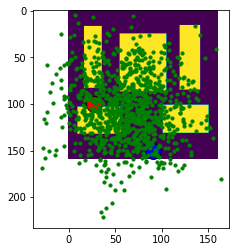

Iter: 41000
Loss: 0.003904

Iter: 42000
Loss: 0.003957

Iter: 43000
Loss: 0.004008

Iter: 44000
Loss: 0.004006

Iter: 45000
Loss: 0.004357

Iter: 46000
Loss: 0.004182

Iter: 47000
Loss: 0.003939

Iter: 48000
Loss: 0.003971

Iter: 49000
Loss: 0.004109

Iter: 50000
Loss: 0.003925



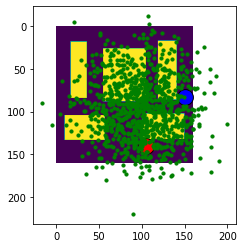

Iter: 51000
Loss: 0.003888

Iter: 52000
Loss: 0.004207

Iter: 53000
Loss: 0.004056

Iter: 54000
Loss: 0.003845

Iter: 55000
Loss: 0.003794

Iter: 56000
Loss: 0.003786

Iter: 57000
Loss: 0.003872

Iter: 58000
Loss: 0.003814

Iter: 59000
Loss: 0.004013

Iter: 60000
Loss: 0.003869



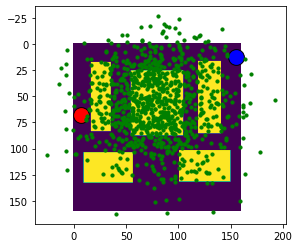

Iter: 61000
Loss: 0.003995

Iter: 62000
Loss: 0.004011

Iter: 63000
Loss: 0.003933

Iter: 64000
Loss: 0.004256

Iter: 65000
Loss: 0.003876

Iter: 66000
Loss: 0.003922

Iter: 67000
Loss: 0.003855

Iter: 68000
Loss: 0.004275

Iter: 69000
Loss: 0.00391

Iter: 70000
Loss: 0.004038



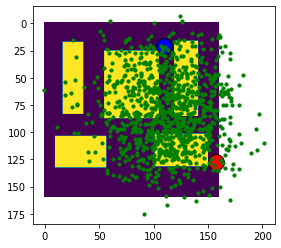

Iter: 71000
Loss: 0.004146

Iter: 72000
Loss: 0.004182

Iter: 73000
Loss: 0.003865

Iter: 74000
Loss: 0.00378

Iter: 75000
Loss: 0.003904

Iter: 76000
Loss: 0.003979

Iter: 77000
Loss: 0.004043

Iter: 78000
Loss: 0.003831

Iter: 79000
Loss: 0.003881

Iter: 80000
Loss: 0.003867



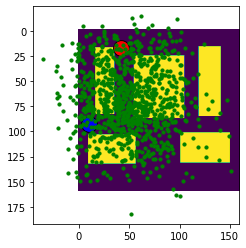

Iter: 81000
Loss: 0.003858

Iter: 82000
Loss: 0.00382

Iter: 83000
Loss: 0.003772

Iter: 84000
Loss: 0.003933

Iter: 85000
Loss: 0.003745

Iter: 86000
Loss: 0.003939

Iter: 87000
Loss: 0.003787

Iter: 88000
Loss: 0.003817

Iter: 89000
Loss: 0.004177

Iter: 90000
Loss: 0.003768



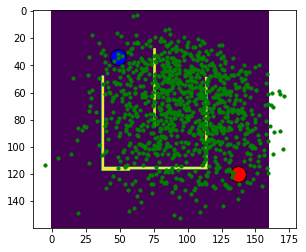

Iter: 91000
Loss: 0.003732

Iter: 92000
Loss: 0.003907

Iter: 93000
Loss: 0.003725

Iter: 94000
Loss: 0.003885

Iter: 95000
Loss: 0.003834

Iter: 96000
Loss: 0.003701

Iter: 97000
Loss: 0.003724

Iter: 98000
Loss: 0.003888

Iter: 99000
Loss: 0.003816

Iter: 100000
Loss: 0.003744



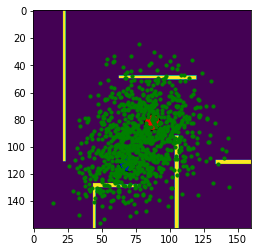

Iter: 101000
Loss: 0.003697

Iter: 102000
Loss: 0.003719

Iter: 103000
Loss: 0.003601

Iter: 104000
Loss: 0.003735

Iter: 105000
Loss: 0.003793

Iter: 106000
Loss: 0.003727

Iter: 107000
Loss: 0.003832

Iter: 108000
Loss: 0.003823

Iter: 109000
Loss: 0.003633

Iter: 110000
Loss: 0.003689



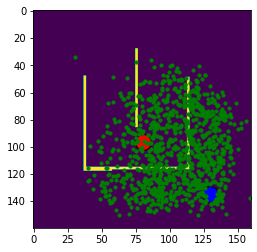

Iter: 111000
Loss: 0.003622

Iter: 112000
Loss: 0.003736

Iter: 113000
Loss: 0.003728

Iter: 114000
Loss: 0.00373

Iter: 115000
Loss: 0.003638

Iter: 116000
Loss: 0.004052

Iter: 117000
Loss: 0.003596

Iter: 118000
Loss: 0.003688

Iter: 119000
Loss: 0.003798

Iter: 120000
Loss: 0.003683



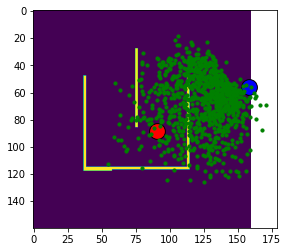

Iter: 121000
Loss: 0.003723

Iter: 122000
Loss: 0.003739

Iter: 123000
Loss: 0.00368

Iter: 124000
Loss: 0.003782

Iter: 125000
Loss: 0.003811

Iter: 126000
Loss: 0.003523

Iter: 127000
Loss: 0.003643

Iter: 128000
Loss: 0.003608

Iter: 129000
Loss: 0.003667

Iter: 130000
Loss: 0.003644



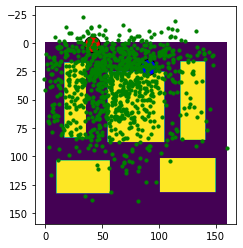

Iter: 131000
Loss: 0.003767

Iter: 132000
Loss: 0.003731

Iter: 133000
Loss: 0.003629

Iter: 134000
Loss: 0.003555

Iter: 135000
Loss: 0.003755

Iter: 136000
Loss: 0.00386

Iter: 137000
Loss: 0.003633

Iter: 138000
Loss: 0.003639

Iter: 139000
Loss: 0.003576

Iter: 140000
Loss: 0.003519



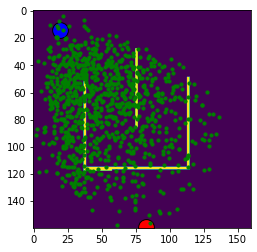

Iter: 141000
Loss: 0.003537

Iter: 142000
Loss: 0.003533

Iter: 143000
Loss: 0.003581

Iter: 144000
Loss: 0.00373

Iter: 145000
Loss: 0.003535

Iter: 146000
Loss: 0.003653

Iter: 147000
Loss: 0.003621

Iter: 148000
Loss: 0.003755

Iter: 149000
Loss: 0.003834

Iter: 150000
Loss: 0.003494



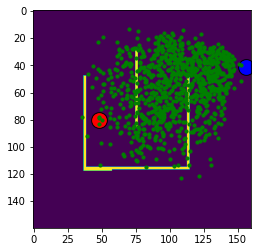

Iter: 151000
Loss: 0.003565

Iter: 152000
Loss: 0.00355

Iter: 153000
Loss: 0.00347

Iter: 154000
Loss: 0.003521

Iter: 155000
Loss: 0.003538

Iter: 156000
Loss: 0.003372

Iter: 157000
Loss: 0.003569

Iter: 158000
Loss: 0.003461

Iter: 159000
Loss: 0.003613

Iter: 160000
Loss: 0.003343



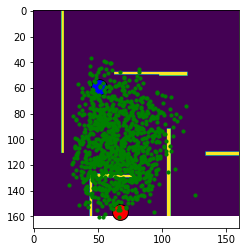

Iter: 161000
Loss: 0.003513

Iter: 162000
Loss: 0.003495

Iter: 163000
Loss: 0.003542

Iter: 164000
Loss: 0.003516

Iter: 165000
Loss: 0.003667

Iter: 166000
Loss: 0.003567

Iter: 167000
Loss: 0.003651

Iter: 168000
Loss: 0.00336

Iter: 169000
Loss: 0.003686

Iter: 170000
Loss: 0.003515



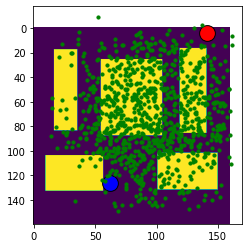

Iter: 171000
Loss: 0.003538

Iter: 172000
Loss: 0.003426

Iter: 173000
Loss: 0.003561

Iter: 174000
Loss: 0.003382

Iter: 175000
Loss: 0.003503

Iter: 176000
Loss: 0.003563

Iter: 177000
Loss: 0.0034

Iter: 178000
Loss: 0.003508

Iter: 179000
Loss: 0.003484

Iter: 180000
Loss: 0.003412



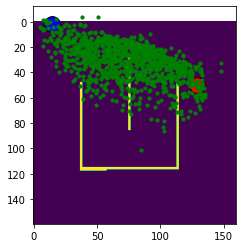

Iter: 181000
Loss: 0.003585

Iter: 182000
Loss: 0.003472

Iter: 183000
Loss: 0.003492

Iter: 184000
Loss: 0.003364

Iter: 185000
Loss: 0.003436

Iter: 186000
Loss: 0.003486

Iter: 187000
Loss: 0.003484

Iter: 188000
Loss: 0.003529

Iter: 189000
Loss: 0.003385

Iter: 190000
Loss: 0.003627



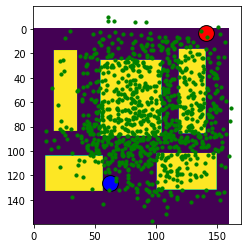

Iter: 191000
Loss: 0.003512

Iter: 192000
Loss: 0.003446

Iter: 193000
Loss: 0.003236

Iter: 194000
Loss: 0.003356

Iter: 195000
Loss: 0.003376

Iter: 196000
Loss: 0.003489

Iter: 197000
Loss: 0.003287

Iter: 198000
Loss: 0.00344

Iter: 199000
Loss: 0.003475

Iter: 200000
Loss: 0.003359



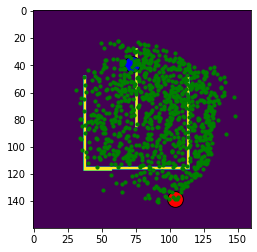

Iter: 201000
Loss: 0.00339

Iter: 202000
Loss: 0.003478

Iter: 203000
Loss: 0.003325

Iter: 204000
Loss: 0.003336

Iter: 205000
Loss: 0.003392

Iter: 206000
Loss: 0.003599

Iter: 207000
Loss: 0.003232

Iter: 208000
Loss: 0.003391

Iter: 209000
Loss: 0.003356

Iter: 210000
Loss: 0.003426



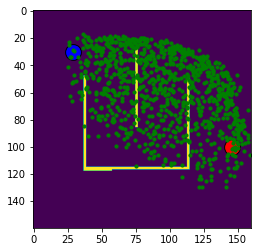

Iter: 211000
Loss: 0.003366

Iter: 212000
Loss: 0.003438

Iter: 213000
Loss: 0.003418

Iter: 214000
Loss: 0.003289

Iter: 215000
Loss: 0.003331

Iter: 216000
Loss: 0.003459

Iter: 217000
Loss: 0.003549

Iter: 218000
Loss: 0.003427

Iter: 219000
Loss: 0.003336

Iter: 220000
Loss: 0.003277



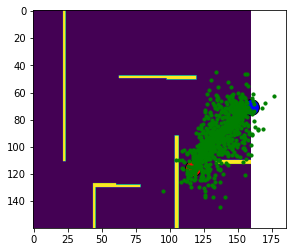

Iter: 221000
Loss: 0.003323

Iter: 222000
Loss: 0.003386

Iter: 223000
Loss: 0.00334

Iter: 224000
Loss: 0.003382

Iter: 225000
Loss: 0.003297

Iter: 226000
Loss: 0.00338

Iter: 227000
Loss: 0.003286

Iter: 228000
Loss: 0.003227

Iter: 229000
Loss: 0.003259

Iter: 230000
Loss: 0.003296



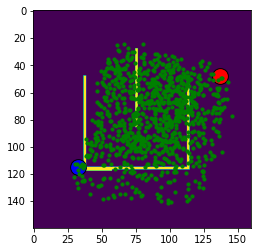

Iter: 231000
Loss: 0.003303

Iter: 232000
Loss: 0.003232

Iter: 233000
Loss: 0.00317

Iter: 234000
Loss: 0.003238

Iter: 235000
Loss: 0.003233

Iter: 236000
Loss: 0.003452

Iter: 237000
Loss: 0.003323

Iter: 238000
Loss: 0.003319

Iter: 239000
Loss: 0.003307

Iter: 240000
Loss: 0.003539



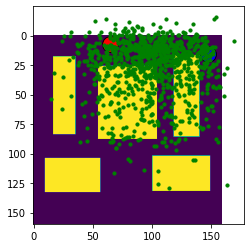

Iter: 241000
Loss: 0.003415

Iter: 242000
Loss: 0.003275

Iter: 243000
Loss: 0.003219

Iter: 244000
Loss: 0.003132

Iter: 245000
Loss: 0.003385

Iter: 246000
Loss: 0.003242

Iter: 247000
Loss: 0.003345

Iter: 248000
Loss: 0.003407

Iter: 249000
Loss: 0.003259

Iter: 250000
Loss: 0.003352



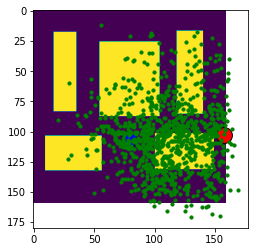

Iter: 251000
Loss: 0.00334

Iter: 252000
Loss: 0.00314

Iter: 253000
Loss: 0.003239

Iter: 254000
Loss: 0.003213

Iter: 255000
Loss: 0.003289

Iter: 256000
Loss: 0.00331

Iter: 257000
Loss: 0.003297

Iter: 258000
Loss: 0.003154

Iter: 259000
Loss: 0.003425

Iter: 260000
Loss: 0.003206



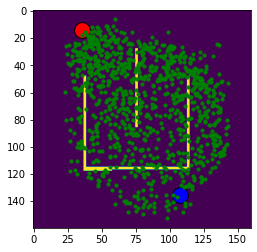

Iter: 261000
Loss: 0.003208

Iter: 262000
Loss: 0.003236

Iter: 263000
Loss: 0.003183

Iter: 264000
Loss: 0.003166

Iter: 265000
Loss: 0.003509

Iter: 266000
Loss: 0.003199

Iter: 267000
Loss: 0.003136

Iter: 268000
Loss: 0.003343

Iter: 269000
Loss: 0.00316

Iter: 270000
Loss: 0.003097



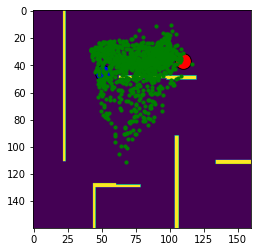

Iter: 271000
Loss: 0.003265

Iter: 272000
Loss: 0.003287

Iter: 273000
Loss: 0.003406

Iter: 274000
Loss: 0.0032

Iter: 275000
Loss: 0.003231

Iter: 276000
Loss: 0.00321

Iter: 277000
Loss: 0.003462

Iter: 278000
Loss: 0.003242

Iter: 279000
Loss: 0.003153

Iter: 280000
Loss: 0.003177



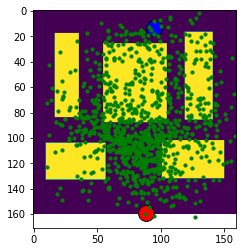

Iter: 281000
Loss: 0.003266

Iter: 282000
Loss: 0.003242

Iter: 283000
Loss: 0.003241

Iter: 284000
Loss: 0.003248

Iter: 285000
Loss: 0.00328

Iter: 286000
Loss: 0.003271

Iter: 287000
Loss: 0.003253

Iter: 288000
Loss: 0.003216

Iter: 289000
Loss: 0.003316

Iter: 290000
Loss: 0.003116



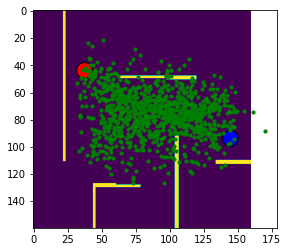

Iter: 291000
Loss: 0.003196

Iter: 292000
Loss: 0.003271

Iter: 293000
Loss: 0.003164

Iter: 294000
Loss: 0.003133

Iter: 295000
Loss: 0.003173

Iter: 296000
Loss: 0.003296

Iter: 297000
Loss: 0.003199

Iter: 298000
Loss: 0.003287

Iter: 299000
Loss: 0.003299

Iter: 300000
Loss: 0.003102



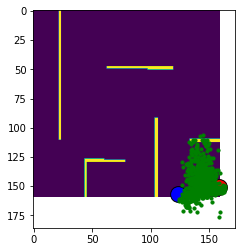

Iter: 301000
Loss: 0.003172

Iter: 302000
Loss: 0.003158

Iter: 303000
Loss: 0.003219

Iter: 304000
Loss: 0.003077

Iter: 305000
Loss: 0.00316

Iter: 306000
Loss: 0.00314

Iter: 307000
Loss: 0.003227

Iter: 308000
Loss: 0.003174

Iter: 309000
Loss: 0.003249

Iter: 310000
Loss: 0.003327



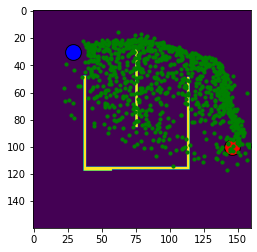

Iter: 311000
Loss: 0.003055

Iter: 312000
Loss: 0.003158

Iter: 313000
Loss: 0.003086

Iter: 314000
Loss: 0.003107

Iter: 315000
Loss: 0.003159

Iter: 316000
Loss: 0.003182

Iter: 317000
Loss: 0.003305

Iter: 318000
Loss: 0.003186

Iter: 319000
Loss: 0.003116

Iter: 320000
Loss: 0.003116



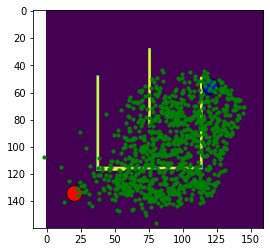

Iter: 321000
Loss: 0.003292

Iter: 322000
Loss: 0.003228

Iter: 323000
Loss: 0.003227

Iter: 324000
Loss: 0.003203

Iter: 325000
Loss: 0.003082

Iter: 326000
Loss: 0.00303

Iter: 327000
Loss: 0.003154

Iter: 328000
Loss: 0.003196

Iter: 329000
Loss: 0.003278

Iter: 330000
Loss: 0.003158



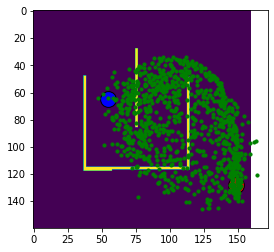

Iter: 331000
Loss: 0.003074

Iter: 332000
Loss: 0.002964

Iter: 333000
Loss: 0.003209

Iter: 334000
Loss: 0.003048

Iter: 335000
Loss: 0.003029

Iter: 336000
Loss: 0.003152

Iter: 337000
Loss: 0.003049

Iter: 338000
Loss: 0.003057

Iter: 339000
Loss: 0.003051

Iter: 340000
Loss: 0.003149



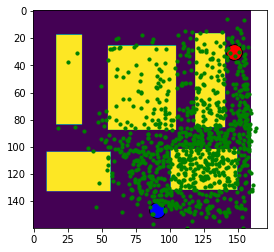

Iter: 341000
Loss: 0.003132

Iter: 342000
Loss: 0.003059

Iter: 343000
Loss: 0.003206

Iter: 344000
Loss: 0.00325

Iter: 345000
Loss: 0.00308

Iter: 346000
Loss: 0.003077

Iter: 347000
Loss: 0.002985

Iter: 348000
Loss: 0.003137

Iter: 349000
Loss: 0.003071

Iter: 350000
Loss: 0.003049



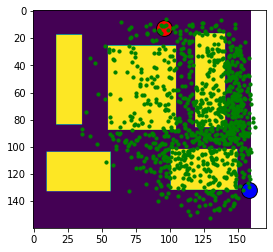

Iter: 351000
Loss: 0.003224

Iter: 352000
Loss: 0.003065

Iter: 353000
Loss: 0.0031

Iter: 354000
Loss: 0.003039

Iter: 355000
Loss: 0.003053

Iter: 356000
Loss: 0.003207

Iter: 357000
Loss: 0.003139

Iter: 358000
Loss: 0.003133

Iter: 359000
Loss: 0.003117

Iter: 360000
Loss: 0.003264



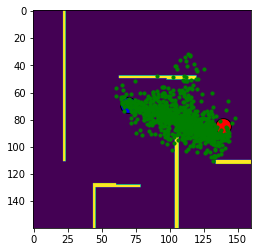

Iter: 361000
Loss: 0.003029

Iter: 362000
Loss: 0.00304

Iter: 363000
Loss: 0.002971

Iter: 364000
Loss: 0.002983

Iter: 365000
Loss: 0.003017

Iter: 366000
Loss: 0.003046

Iter: 367000
Loss: 0.003085

Iter: 368000
Loss: 0.003079

Iter: 369000
Loss: 0.003031

Iter: 370000
Loss: 0.003057



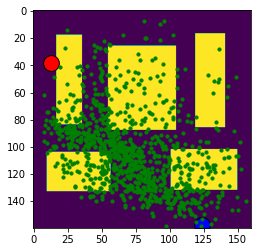

Iter: 371000
Loss: 0.003073

Iter: 372000
Loss: 0.00315

Iter: 373000
Loss: 0.003014

Iter: 374000
Loss: 0.003107

Iter: 375000
Loss: 0.002986

Iter: 376000
Loss: 0.003176

Iter: 377000
Loss: 0.003123

Iter: 378000
Loss: 0.003136

Iter: 379000
Loss: 0.003177

Iter: 380000
Loss: 0.003093



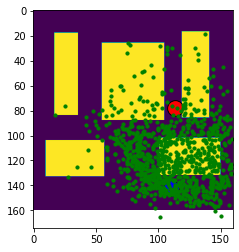

Iter: 381000
Loss: 0.003146

Iter: 382000
Loss: 0.002974

Iter: 383000
Loss: 0.00294

Iter: 384000
Loss: 0.003132

Iter: 385000
Loss: 0.003056

Iter: 386000
Loss: 0.003048

Iter: 387000
Loss: 0.003095

Iter: 388000
Loss: 0.002944

Iter: 389000
Loss: 0.003151

Iter: 390000
Loss: 0.003042



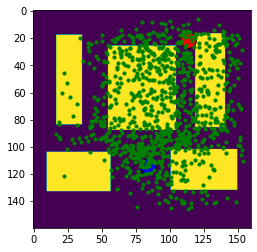

Iter: 391000
Loss: 0.002963

Iter: 392000
Loss: 0.003184

Iter: 393000
Loss: 0.002943

Iter: 394000
Loss: 0.003117

Iter: 395000
Loss: 0.003002

Iter: 396000
Loss: 0.003114

Iter: 397000
Loss: 0.003096

Iter: 398000
Loss: 0.003026

Iter: 399000
Loss: 0.003041

Iter: 400000
Loss: 0.003027



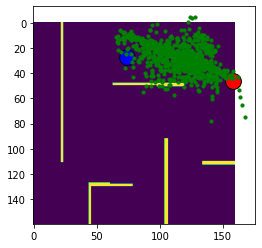

Iter: 401000
Loss: 0.002966

Iter: 402000
Loss: 0.002994

Iter: 403000
Loss: 0.003027

Iter: 404000
Loss: 0.003136

Iter: 405000
Loss: 0.002964

Iter: 406000
Loss: 0.002934

Iter: 407000
Loss: 0.00314

Iter: 408000
Loss: 0.002995

Iter: 409000
Loss: 0.002997

Iter: 410000
Loss: 0.003019



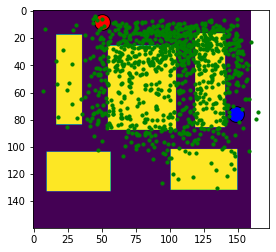

Iter: 411000
Loss: 0.00295

Iter: 412000
Loss: 0.002939

Iter: 413000
Loss: 0.003172

Iter: 414000
Loss: 0.003077

Iter: 415000
Loss: 0.003078

Iter: 416000
Loss: 0.003016

Iter: 417000
Loss: 0.003026

Iter: 418000
Loss: 0.003

Iter: 419000
Loss: 0.003165

Iter: 420000
Loss: 0.003054



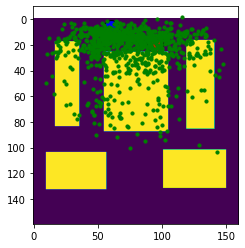

Iter: 421000
Loss: 0.002978

Iter: 422000
Loss: 0.002917

Iter: 423000
Loss: 0.003076

Iter: 424000
Loss: 0.002988

Iter: 425000
Loss: 0.002993

Iter: 426000
Loss: 0.00304

Iter: 427000
Loss: 0.002968

Iter: 428000
Loss: 0.003032

Iter: 429000
Loss: 0.002989

Iter: 430000
Loss: 0.003052



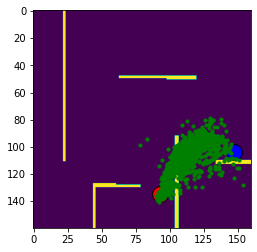

Iter: 431000
Loss: 0.002928

Iter: 432000
Loss: 0.002835

Iter: 433000
Loss: 0.002925

Iter: 434000
Loss: 0.002941

Iter: 435000
Loss: 0.002983

Iter: 436000
Loss: 0.002998

Iter: 437000
Loss: 0.002865

Iter: 438000
Loss: 0.003083

Iter: 439000
Loss: 0.00319

Iter: 440000
Loss: 0.002988



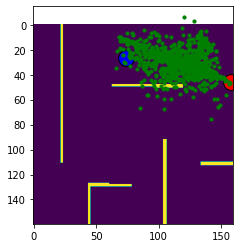

Iter: 441000
Loss: 0.003015

Iter: 442000
Loss: 0.002966

Iter: 443000
Loss: 0.003075

Iter: 444000
Loss: 0.003088

Iter: 445000
Loss: 0.003073

Iter: 446000
Loss: 0.002904

Iter: 447000
Loss: 0.002993

Iter: 448000
Loss: 0.003159

Iter: 449000
Loss: 0.003145

Iter: 450000
Loss: 0.003002



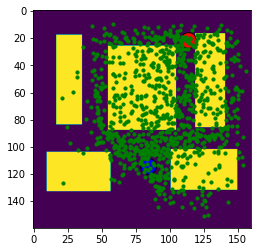

Iter: 451000
Loss: 0.002944

Iter: 452000
Loss: 0.002985

Iter: 453000
Loss: 0.002997

Iter: 454000
Loss: 0.002937

Iter: 455000
Loss: 0.003032

Iter: 456000
Loss: 0.002869

Iter: 457000
Loss: 0.002936

Iter: 458000
Loss: 0.002954

Iter: 459000
Loss: 0.002871

Iter: 460000
Loss: 0.002909



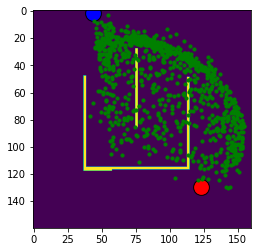

Iter: 461000
Loss: 0.002939

Iter: 462000
Loss: 0.00304

Iter: 463000
Loss: 0.003207

Iter: 464000
Loss: 0.002982

Iter: 465000
Loss: 0.002997

Iter: 466000
Loss: 0.002952

Iter: 467000
Loss: 0.003028

Iter: 468000
Loss: 0.002953

Iter: 469000
Loss: 0.003006

Iter: 470000
Loss: 0.002964



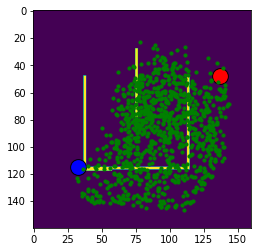

Iter: 471000
Loss: 0.002923

Iter: 472000
Loss: 0.002819

Iter: 473000
Loss: 0.003028

Iter: 474000
Loss: 0.00296

Iter: 475000
Loss: 0.00297

Iter: 476000
Loss: 0.002962

Iter: 477000
Loss: 0.003116

Iter: 478000
Loss: 0.002849

Iter: 479000
Loss: 0.002918

Iter: 480000
Loss: 0.002945



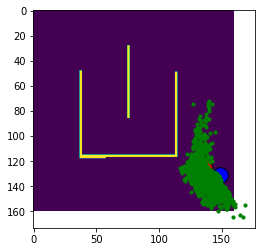

Iter: 481000
Loss: 0.002987

Iter: 482000
Loss: 0.002899

Iter: 483000
Loss: 0.002912

Iter: 484000
Loss: 0.002918

Iter: 485000
Loss: 0.002982

Iter: 486000
Loss: 0.003013

Iter: 487000
Loss: 0.002937

Iter: 488000
Loss: 0.002929

Iter: 489000
Loss: 0.002949

Iter: 490000
Loss: 0.002848



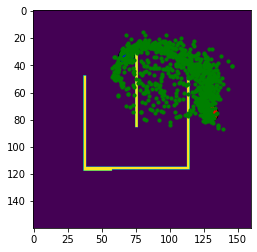

Iter: 491000
Loss: 0.002776

Iter: 492000
Loss: 0.0029

Iter: 493000
Loss: 0.002938

Iter: 494000
Loss: 0.002906

Iter: 495000
Loss: 0.002874

Iter: 496000
Loss: 0.00292

Iter: 497000
Loss: 0.002903

Iter: 498000
Loss: 0.002946

Iter: 499000
Loss: 0.002934

Iter: 500000
Loss: 0.002876



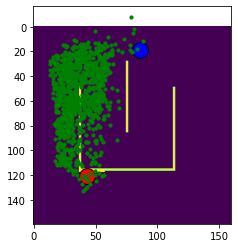

Iter: 501000
Loss: 0.002913

Iter: 502000
Loss: 0.002938

Iter: 503000
Loss: 0.0029

Iter: 504000
Loss: 0.002862

Iter: 505000
Loss: 0.002885

Iter: 506000
Loss: 0.002926

Iter: 507000
Loss: 0.002973

Iter: 508000
Loss: 0.002895

Iter: 509000
Loss: 0.002889

Iter: 510000
Loss: 0.003004



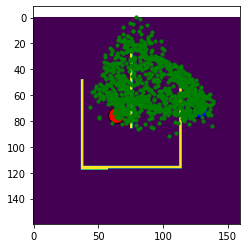

Iter: 511000
Loss: 0.002952

Iter: 512000
Loss: 0.002867

Iter: 513000
Loss: 0.002877

Iter: 514000
Loss: 0.003047

Iter: 515000
Loss: 0.002969

Iter: 516000
Loss: 0.002878

Iter: 517000
Loss: 0.002901

Iter: 518000
Loss: 0.002921

Iter: 519000
Loss: 0.003007

Iter: 520000
Loss: 0.002946



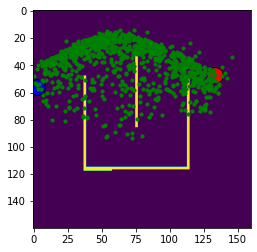

Iter: 521000
Loss: 0.002843

Iter: 522000
Loss: 0.002858

Iter: 523000
Loss: 0.002815

Iter: 524000
Loss: 0.002813

Iter: 525000
Loss: 0.002914

Iter: 526000
Loss: 0.002838

Iter: 527000
Loss: 0.003029

Iter: 528000
Loss: 0.003005

Iter: 529000
Loss: 0.002789

Iter: 530000
Loss: 0.002938



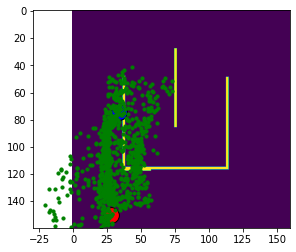

Iter: 531000
Loss: 0.002896

Iter: 532000
Loss: 0.002898

Iter: 533000
Loss: 0.002844

Iter: 534000
Loss: 0.00284

Iter: 535000
Loss: 0.002857

Iter: 536000
Loss: 0.002966

Iter: 537000
Loss: 0.002953

Iter: 538000
Loss: 0.003031

Iter: 539000
Loss: 0.002828

Iter: 540000
Loss: 0.002799



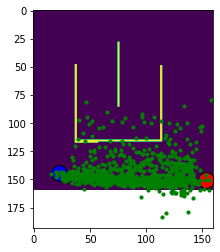

Iter: 541000
Loss: 0.002961

Iter: 542000
Loss: 0.002829

Iter: 543000
Loss: 0.002829

Iter: 544000
Loss: 0.002879

Iter: 545000
Loss: 0.002924

Iter: 546000
Loss: 0.00292

Iter: 547000
Loss: 0.002925

Iter: 548000
Loss: 0.002886

Iter: 549000
Loss: 0.002978

Iter: 550000
Loss: 0.00287



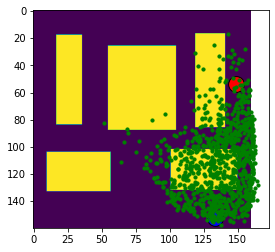

Iter: 551000
Loss: 0.002845

Iter: 552000
Loss: 0.00288

Iter: 553000
Loss: 0.002921

Iter: 554000
Loss: 0.00282

Iter: 555000
Loss: 0.002851

Iter: 556000
Loss: 0.002807

Iter: 557000
Loss: 0.002746

Iter: 558000
Loss: 0.002796

Iter: 559000
Loss: 0.003068

Iter: 560000
Loss: 0.002779



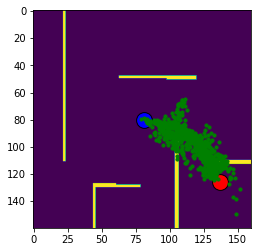

Iter: 561000
Loss: 0.002812

Iter: 562000
Loss: 0.00283

Iter: 563000
Loss: 0.002936

Iter: 564000
Loss: 0.002797

Iter: 565000
Loss: 0.002831

Iter: 566000
Loss: 0.002831

Iter: 567000
Loss: 0.002822

Iter: 568000
Loss: 0.002831

Iter: 569000
Loss: 0.002984

Iter: 570000
Loss: 0.002938



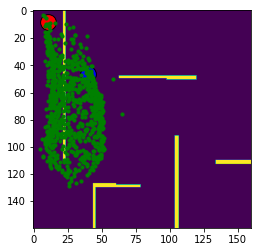

Iter: 571000
Loss: 0.002781

Iter: 572000
Loss: 0.002788

Iter: 573000
Loss: 0.002905

Iter: 574000
Loss: 0.002851

Iter: 575000
Loss: 0.002793

Iter: 576000
Loss: 0.002795

Iter: 577000
Loss: 0.002865

Iter: 578000
Loss: 0.003067

Iter: 579000
Loss: 0.002876

Iter: 580000
Loss: 0.002794



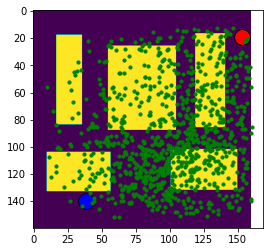

Iter: 581000
Loss: 0.002896

Iter: 582000
Loss: 0.002865

Iter: 583000
Loss: 0.002752

Iter: 584000
Loss: 0.002838

Iter: 585000
Loss: 0.002943

Iter: 586000
Loss: 0.002819

Iter: 587000
Loss: 0.002829

Iter: 588000
Loss: 0.002856

Iter: 589000
Loss: 0.002992

Iter: 590000
Loss: 0.002767



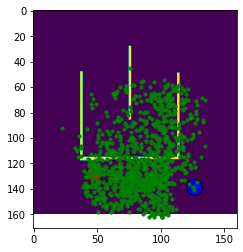

Iter: 591000
Loss: 0.002922

Iter: 592000
Loss: 0.00282

Iter: 593000
Loss: 0.00282

Iter: 594000
Loss: 0.002849

Iter: 595000
Loss: 0.002883

Iter: 596000
Loss: 0.002837

Iter: 597000
Loss: 0.002883

Iter: 598000
Loss: 0.002809

Iter: 599000
Loss: 0.002726

Iter: 600000
Loss: 0.002879



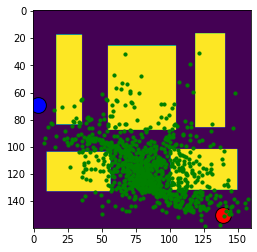

Iter: 601000
Loss: 0.002865

Iter: 602000
Loss: 0.002814

Iter: 603000
Loss: 0.0028

Iter: 604000
Loss: 0.002794

Iter: 605000
Loss: 0.00276

Iter: 606000
Loss: 0.002855

Iter: 607000
Loss: 0.002791

Iter: 608000
Loss: 0.002953

Iter: 609000
Loss: 0.00286

Iter: 610000
Loss: 0.002846



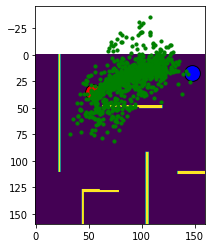

Iter: 611000
Loss: 0.002853

Iter: 612000
Loss: 0.002876

Iter: 613000
Loss: 0.002811

Iter: 614000
Loss: 0.002827

Iter: 615000
Loss: 0.002878

Iter: 616000
Loss: 0.002938

Iter: 617000
Loss: 0.002802

Iter: 618000
Loss: 0.002842

Iter: 619000
Loss: 0.002889

Iter: 620000
Loss: 0.002849



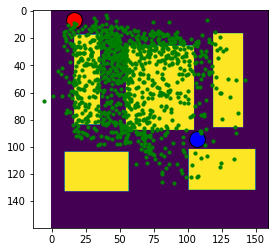

Iter: 621000
Loss: 0.002752

Iter: 622000
Loss: 0.002757

Iter: 623000
Loss: 0.002801

Iter: 624000
Loss: 0.002758

Iter: 625000
Loss: 0.002798

Iter: 626000
Loss: 0.002787

Iter: 627000
Loss: 0.002796

Iter: 628000
Loss: 0.002828

Iter: 629000
Loss: 0.002774

Iter: 630000
Loss: 0.002802



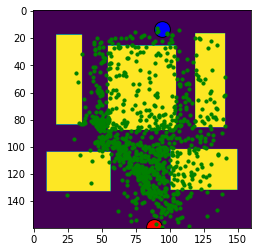

Iter: 631000
Loss: 0.002767

Iter: 632000
Loss: 0.002826

Iter: 633000
Loss: 0.002781

Iter: 634000
Loss: 0.002759

Iter: 635000
Loss: 0.002852

Iter: 636000
Loss: 0.002843

Iter: 637000
Loss: 0.003117

Iter: 638000
Loss: 0.002884

Iter: 639000
Loss: 0.002738

Iter: 640000
Loss: 0.003019



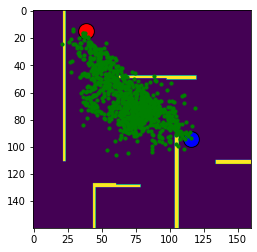

Iter: 641000
Loss: 0.002866

Iter: 642000
Loss: 0.00289

Iter: 643000
Loss: 0.002891

Iter: 644000
Loss: 0.002948

Iter: 645000
Loss: 0.002857

Iter: 646000
Loss: 0.002879

Iter: 647000
Loss: 0.002958

Iter: 648000
Loss: 0.002776

Iter: 649000
Loss: 0.002873

Iter: 650000
Loss: 0.002917



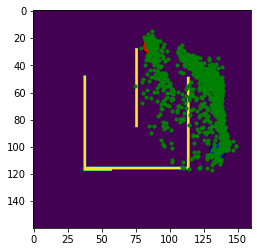

Iter: 651000
Loss: 0.002819

Iter: 652000
Loss: 0.002861

Iter: 653000
Loss: 0.002721

Iter: 654000
Loss: 0.002868

Iter: 655000
Loss: 0.00278

Iter: 656000
Loss: 0.002755

Iter: 657000
Loss: 0.002746

Iter: 658000
Loss: 0.002771

Iter: 659000
Loss: 0.002826

Iter: 660000
Loss: 0.002851



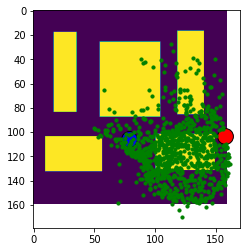

Iter: 661000
Loss: 0.002809

Iter: 662000
Loss: 0.002795

Iter: 663000
Loss: 0.002931

Iter: 664000
Loss: 0.00282

Iter: 665000
Loss: 0.002761

Iter: 666000
Loss: 0.002855

Iter: 667000
Loss: 0.002863

Iter: 668000
Loss: 0.002845

Iter: 669000
Loss: 0.002849

Iter: 670000
Loss: 0.002789



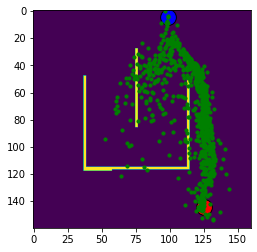

Iter: 671000
Loss: 0.002767

Iter: 672000
Loss: 0.00281

Iter: 673000
Loss: 0.002742

Iter: 674000
Loss: 0.002796

Iter: 675000
Loss: 0.002756

Iter: 676000
Loss: 0.002815

Iter: 677000
Loss: 0.002752

Iter: 678000
Loss: 0.002702

Iter: 679000
Loss: 0.00272

Iter: 680000
Loss: 0.00275



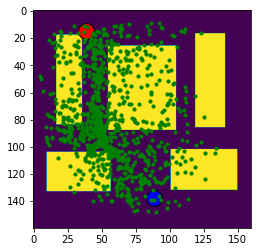

Iter: 681000
Loss: 0.002726

Iter: 682000
Loss: 0.002738

Iter: 683000
Loss: 0.002667

Iter: 684000
Loss: 0.002755

Iter: 685000
Loss: 0.002798

Iter: 686000
Loss: 0.002834

Iter: 687000
Loss: 0.002887

Iter: 688000
Loss: 0.002748

Iter: 689000
Loss: 0.002895

Iter: 690000
Loss: 0.002818



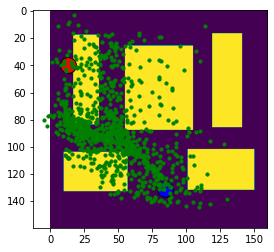

Iter: 691000
Loss: 0.002703

Iter: 692000
Loss: 0.002784

Iter: 693000
Loss: 0.00298

Iter: 694000
Loss: 0.002893

Iter: 695000
Loss: 0.00283

Iter: 696000
Loss: 0.002779

Iter: 697000
Loss: 0.002768

Iter: 698000
Loss: 0.003143

Iter: 699000
Loss: 0.002778

Iter: 700000
Loss: 0.003014



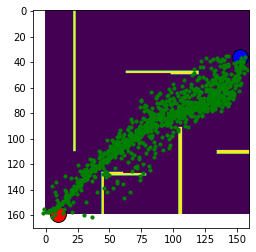

Iter: 701000
Loss: 0.002843

Iter: 702000
Loss: 0.002725

Iter: 703000
Loss: 0.00271

Iter: 704000
Loss: 0.002766

Iter: 705000
Loss: 0.002773

Iter: 706000
Loss: 0.002863

Iter: 707000
Loss: 0.002787

Iter: 708000
Loss: 0.002874

Iter: 709000
Loss: 0.002713

Iter: 710000
Loss: 0.002829



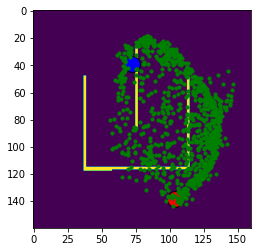

Iter: 711000
Loss: 0.002805

Iter: 712000
Loss: 0.00283

Iter: 713000
Loss: 0.002738

Iter: 714000
Loss: 0.002751

Iter: 715000
Loss: 0.002726

Iter: 716000
Loss: 0.002737

Iter: 717000
Loss: 0.002813

Iter: 718000
Loss: 0.002777

Iter: 719000
Loss: 0.002762

Iter: 720000
Loss: 0.002905



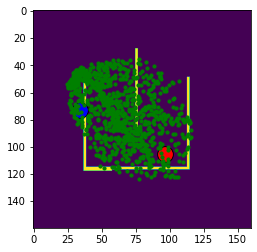

Iter: 721000
Loss: 0.002674

Iter: 722000
Loss: 0.002776

Iter: 723000
Loss: 0.002741

Iter: 724000
Loss: 0.002945

Iter: 725000
Loss: 0.002813

Iter: 726000
Loss: 0.002866

Iter: 727000
Loss: 0.002662

Iter: 728000
Loss: 0.002825

Iter: 729000
Loss: 0.002746

Iter: 730000
Loss: 0.002787



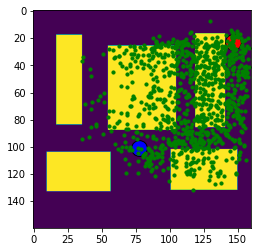

Iter: 731000
Loss: 0.002651

Iter: 732000
Loss: 0.002682

Iter: 733000
Loss: 0.002734

Iter: 734000
Loss: 0.002838

Iter: 735000
Loss: 0.002884

Iter: 736000
Loss: 0.002915

Iter: 737000
Loss: 0.002778

Iter: 738000
Loss: 0.002834

Iter: 739000
Loss: 0.002934

Iter: 740000
Loss: 0.002717



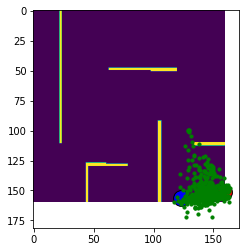

Iter: 741000
Loss: 0.002738

Iter: 742000
Loss: 0.002836

Iter: 743000
Loss: 0.002757

Iter: 744000
Loss: 0.00272

Iter: 745000
Loss: 0.002767

Iter: 746000
Loss: 0.002684

Iter: 747000
Loss: 0.002718

Iter: 748000
Loss: 0.002744

Iter: 749000
Loss: 0.002765

Iter: 750000
Loss: 0.002636



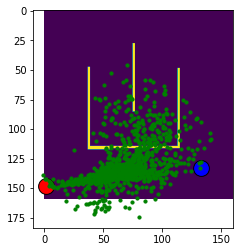

Iter: 751000
Loss: 0.002741

Iter: 752000
Loss: 0.002705

Iter: 753000
Loss: 0.002648

Iter: 754000
Loss: 0.002734

Iter: 755000
Loss: 0.002849

Iter: 756000
Loss: 0.002679

Iter: 757000
Loss: 0.002653

Iter: 758000
Loss: 0.002721

Iter: 759000
Loss: 0.002714

Iter: 760000
Loss: 0.002648



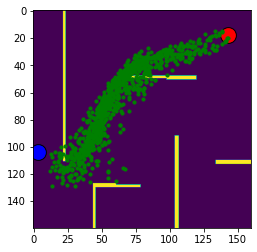

Iter: 761000
Loss: 0.002711

Iter: 762000
Loss: 0.002691

Iter: 763000
Loss: 0.002654

Iter: 764000
Loss: 0.002817

Iter: 765000
Loss: 0.002729

Iter: 766000
Loss: 0.002791

Iter: 767000
Loss: 0.002577

Iter: 768000
Loss: 0.002781

Iter: 769000
Loss: 0.002808

Iter: 770000
Loss: 0.00275



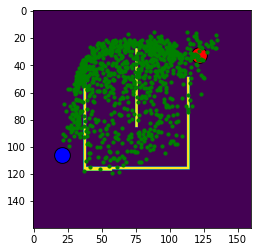

Iter: 771000
Loss: 0.002725

Iter: 772000
Loss: 0.002777

Iter: 773000
Loss: 0.002632

Iter: 774000
Loss: 0.002761

Iter: 775000
Loss: 0.002733

Iter: 776000
Loss: 0.002767

Iter: 777000
Loss: 0.002701

Iter: 778000
Loss: 0.002843

Iter: 779000
Loss: 0.002765

Iter: 780000
Loss: 0.002819



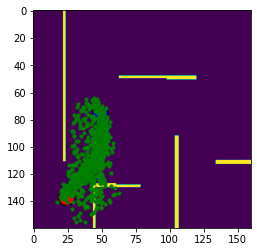

Iter: 781000
Loss: 0.002819

Iter: 782000
Loss: 0.002736

Iter: 783000
Loss: 0.002723

Iter: 784000
Loss: 0.002716

Iter: 785000
Loss: 0.002688

Iter: 786000
Loss: 0.0027

Iter: 787000
Loss: 0.002903

Iter: 788000
Loss: 0.00275

Iter: 789000
Loss: 0.002787

Iter: 790000
Loss: 0.002704



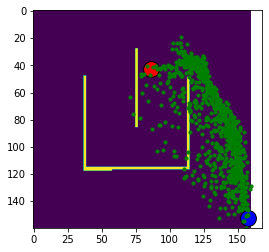

Iter: 791000
Loss: 0.002685

Iter: 792000
Loss: 0.002849

Iter: 793000
Loss: 0.002669

Iter: 794000
Loss: 0.002788

Iter: 795000
Loss: 0.002801

Iter: 796000
Loss: 0.002753

Iter: 797000
Loss: 0.002876

Iter: 798000
Loss: 0.002705

Iter: 799000
Loss: 0.00271

Iter: 800000
Loss: 0.002707



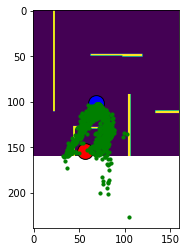

Iter: 801000
Loss: 0.002748

Iter: 802000
Loss: 0.00266

Iter: 803000
Loss: 0.002584

Iter: 804000
Loss: 0.002669

Iter: 805000
Loss: 0.002775

Iter: 806000
Loss: 0.00269

Iter: 807000
Loss: 0.002729

Iter: 808000
Loss: 0.002765

Iter: 809000
Loss: 0.002729

Iter: 810000
Loss: 0.002702



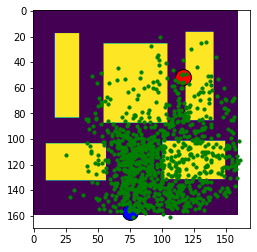

Iter: 811000
Loss: 0.002679

Iter: 812000
Loss: 0.002712

Iter: 813000
Loss: 0.002813

Iter: 814000
Loss: 0.00267

Iter: 815000
Loss: 0.002588

Iter: 816000
Loss: 0.002777

Iter: 817000
Loss: 0.002635

Iter: 818000
Loss: 0.002586

Iter: 819000
Loss: 0.002863

Iter: 820000
Loss: 0.002748



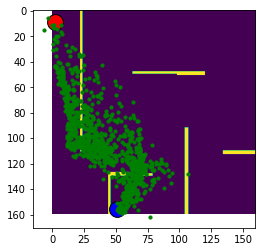

Iter: 821000
Loss: 0.002633

Iter: 822000
Loss: 0.002815

Iter: 823000
Loss: 0.002644

Iter: 824000
Loss: 0.002662

Iter: 825000
Loss: 0.002684

Iter: 826000
Loss: 0.002725

Iter: 827000
Loss: 0.002702

Iter: 828000
Loss: 0.002576

Iter: 829000
Loss: 0.002671

Iter: 830000
Loss: 0.002661



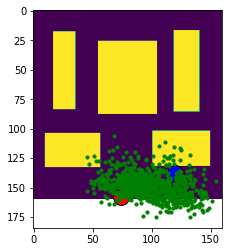

Iter: 831000
Loss: 0.002775

Iter: 832000
Loss: 0.002678

Iter: 833000
Loss: 0.002724

Iter: 834000
Loss: 0.002672

Iter: 835000
Loss: 0.002727

Iter: 836000
Loss: 0.002702

Iter: 837000
Loss: 0.002637

Iter: 838000
Loss: 0.002642

Iter: 839000
Loss: 0.002705

Iter: 840000
Loss: 0.0029



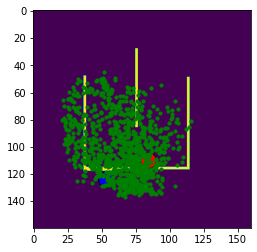

Iter: 841000
Loss: 0.002718

Iter: 842000
Loss: 0.002745

Iter: 843000
Loss: 0.002761

Iter: 844000
Loss: 0.00267

Iter: 845000
Loss: 0.002873

Iter: 846000
Loss: 0.002665

Iter: 847000
Loss: 0.00271

Iter: 848000
Loss: 0.00259

Iter: 849000
Loss: 0.002652

Iter: 850000
Loss: 0.002655



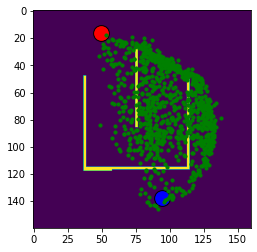

Iter: 851000
Loss: 0.002672

Iter: 852000
Loss: 0.002638

Iter: 853000
Loss: 0.002726

Iter: 854000
Loss: 0.002762

Iter: 855000
Loss: 0.00264

Iter: 856000
Loss: 0.002719

Iter: 857000
Loss: 0.002664

Iter: 858000
Loss: 0.002668

Iter: 859000
Loss: 0.002686

Iter: 860000
Loss: 0.002664



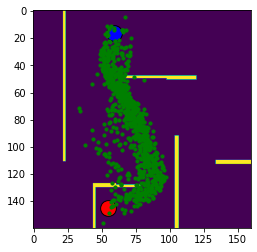

Iter: 861000
Loss: 0.002679

Iter: 862000
Loss: 0.002684

Iter: 863000
Loss: 0.00262

Iter: 864000
Loss: 0.002617

Iter: 865000
Loss: 0.002752

Iter: 866000
Loss: 0.002639

Iter: 867000
Loss: 0.00269

Iter: 868000
Loss: 0.002687

Iter: 869000
Loss: 0.002776

Iter: 870000
Loss: 0.002652



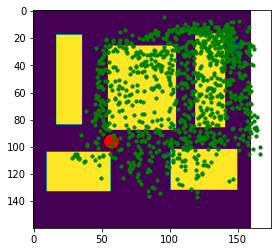

Iter: 871000
Loss: 0.00274

Iter: 872000
Loss: 0.002927

Iter: 873000
Loss: 0.002619

Iter: 874000
Loss: 0.00267

Iter: 875000
Loss: 0.002544

Iter: 876000
Loss: 0.002679

Iter: 877000
Loss: 0.002653

Iter: 878000
Loss: 0.002746

Iter: 879000
Loss: 0.00274

Iter: 880000
Loss: 0.002699



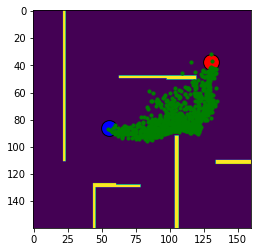

Iter: 881000
Loss: 0.002732

Iter: 882000
Loss: 0.002641

Iter: 883000
Loss: 0.002747

Iter: 884000
Loss: 0.002551

Iter: 885000
Loss: 0.002742

Iter: 886000
Loss: 0.002635

Iter: 887000
Loss: 0.002621

Iter: 888000
Loss: 0.002684

Iter: 889000
Loss: 0.00265

Iter: 890000
Loss: 0.002629



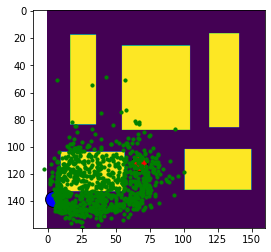

Iter: 891000
Loss: 0.002645

Iter: 892000
Loss: 0.002657

Iter: 893000
Loss: 0.002562

Iter: 894000
Loss: 0.002617

Iter: 895000
Loss: 0.002628

Iter: 896000
Loss: 0.002653

Iter: 897000
Loss: 0.002792

Iter: 898000
Loss: 0.00267

Iter: 899000
Loss: 0.00267

Iter: 900000
Loss: 0.002633



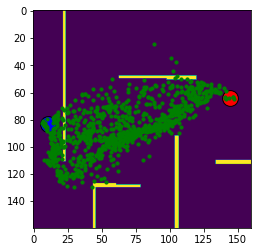

Iter: 901000
Loss: 0.002626

Iter: 902000
Loss: 0.00273

Iter: 903000
Loss: 0.002712

Iter: 904000
Loss: 0.002677

Iter: 905000
Loss: 0.00268

Iter: 906000
Loss: 0.002761

Iter: 907000
Loss: 0.002782

Iter: 908000
Loss: 0.002598

Iter: 909000
Loss: 0.002691

Iter: 910000
Loss: 0.002709



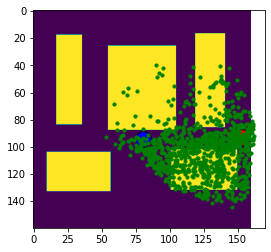

Iter: 911000
Loss: 0.002648

Iter: 912000
Loss: 0.002604

Iter: 913000
Loss: 0.002661

Iter: 914000
Loss: 0.002621

Iter: 915000
Loss: 0.002637

Iter: 916000
Loss: 0.002731

Iter: 917000
Loss: 0.002627

Iter: 918000
Loss: 0.002681

Iter: 919000
Loss: 0.002651

Iter: 920000
Loss: 0.002661



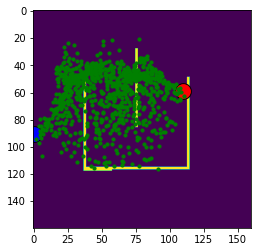

Iter: 921000
Loss: 0.002749

Iter: 922000
Loss: 0.002702

Iter: 923000
Loss: 0.002608

Iter: 924000
Loss: 0.002643

Iter: 925000
Loss: 0.002787

Iter: 926000
Loss: 0.002722

Iter: 927000
Loss: 0.002653

Iter: 928000
Loss: 0.00263

Iter: 929000
Loss: 0.002715

Iter: 930000
Loss: 0.002769



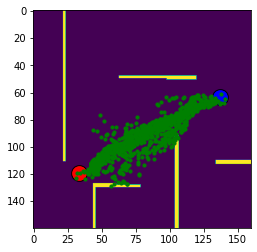

Iter: 931000
Loss: 0.002654

Iter: 932000
Loss: 0.002627

Iter: 933000
Loss: 0.002648

Iter: 934000
Loss: 0.002619

Iter: 935000
Loss: 0.002712

Iter: 936000
Loss: 0.002768

Iter: 937000
Loss: 0.00272

Iter: 938000
Loss: 0.002624

Iter: 939000
Loss: 0.002638

Iter: 940000
Loss: 0.002583



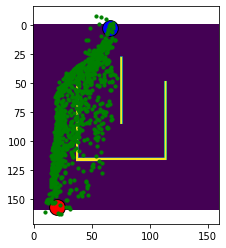

Iter: 941000
Loss: 0.002825

Iter: 942000
Loss: 0.00268

Iter: 943000
Loss: 0.002697

Iter: 944000
Loss: 0.002618

Iter: 945000
Loss: 0.002653

Iter: 946000
Loss: 0.002758

Iter: 947000
Loss: 0.00263

Iter: 948000
Loss: 0.002588

Iter: 949000
Loss: 0.002684

Iter: 950000
Loss: 0.002745



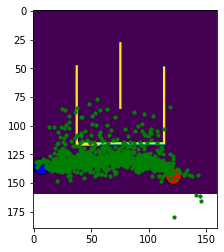

Iter: 951000
Loss: 0.002602

Iter: 952000
Loss: 0.002665

Iter: 953000
Loss: 0.002672

Iter: 954000
Loss: 0.002689

Iter: 955000
Loss: 0.002652

Iter: 956000
Loss: 0.002596

Iter: 957000
Loss: 0.002597

Iter: 958000
Loss: 0.00277

Iter: 959000
Loss: 0.002615

Iter: 960000
Loss: 0.002702



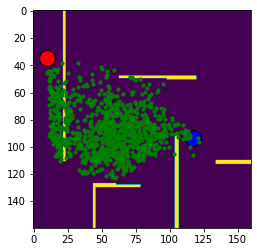

Iter: 961000
Loss: 0.002617

Iter: 962000
Loss: 0.002673

Iter: 963000
Loss: 0.002649

Iter: 964000
Loss: 0.002635

Iter: 965000
Loss: 0.002716

Iter: 966000
Loss: 0.002589

Iter: 967000
Loss: 0.002632

Iter: 968000
Loss: 0.002638

Iter: 969000
Loss: 0.002579

Iter: 970000
Loss: 0.002682



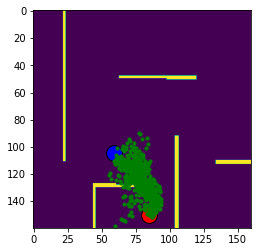

Iter: 971000
Loss: 0.002664

Iter: 972000
Loss: 0.002652

Iter: 973000
Loss: 0.002701

Iter: 974000
Loss: 0.002649

Iter: 975000
Loss: 0.002598

Iter: 976000
Loss: 0.002584

Iter: 977000
Loss: 0.00256

Iter: 978000
Loss: 0.002636

Iter: 979000
Loss: 0.002585

Iter: 980000
Loss: 0.002598



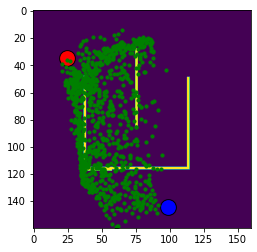

Iter: 981000
Loss: 0.002638

Iter: 982000
Loss: 0.002643

Iter: 983000
Loss: 0.002589

Iter: 984000
Loss: 0.00261

Iter: 985000
Loss: 0.002649

Iter: 986000
Loss: 0.002571

Iter: 987000
Loss: 0.002667

Iter: 988000
Loss: 0.002653

Iter: 989000
Loss: 0.002673

Iter: 990000
Loss: 0.002643



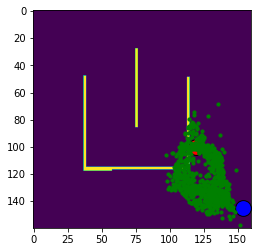

Iter: 991000
Loss: 0.002585

Iter: 992000
Loss: 0.002736

Iter: 993000
Loss: 0.002733

Iter: 994000
Loss: 0.002655

Iter: 995000
Loss: 0.002637

Iter: 996000
Loss: 0.002706

Iter: 997000
Loss: 0.002524

Iter: 998000
Loss: 0.002644

Iter: 999000
Loss: 0.002605



In [11]:
# Train  model and save weights after each ITERS_PER_SAVE
saver = tf.train.Saver()
for i in range(it, TRAIN_ITERS):
    # randomly generate batches
    batch_elements = [randint(0,numTrain-1) for n in range(0,mb_size)]
    X_mb = x_train[batch_elements,:]
    c_mb = cond_train[batch_elements,:]

    _, loss = sess.run([train_step, cvae_loss], feed_dict={X: X_mb, c: c_mb})

    if i % 1000 == 0:
        print('Iter: {}'.format(i))
        print('Loss: {:.4}'. format(loss))
        print()
    if i % ITERS_PER_SAVE == 0:
      checkpoint_filename = os.path.join(DATA_ROOT, 'trained_weights/final_train_iter_%d' % i)
      saver.save(sess, checkpoint_filename, write_meta_graph=False)
      NUM_SAMPLES = 1000  # number of samples for model to generate
      rand_test_i = randint(0,numTest-1)
      rand_cond = cond_test[rand_test_i, :]
    
      # [iy, ix, iz, gy, gx, gt, map....]
      # init, goal = rand_cond[0, 3:5], samples_data[0, 6:8]
      init = rand_cond[0:1+1] * SAMPLE_SCALE_UP
      goal = rand_cond[3:4+1] * SAMPLE_SCALE_UP

      # figure out which  maps this random sample condition for visualization
      mini_map = rand_cond[2*STATE_DIM:]
      for map_num, unrolled_map in train_maps.items():
        if np.sum(unrolled_map - mini_map) == 0:
          orig_map = all_orig_maps[map_num]
          break

      # same condition repeated NUM_SAMPLES times
      cond_samples = np.repeat([rand_cond],NUM_SAMPLES,axis=0)  

      # directly sample from the latent space to generate predicted samples
      gen_samples, _ = sess.run([y, z], feed_dict={z: np.random.randn(NUM_SAMPLES, z_dim), c: cond_samples})
      # scale up samples to original map dimension
      gen_samples = gen_samples * SAMPLE_SCALE_UP
      
      plt.imshow(orig_map)

      plt.scatter(x=init[1], y=init[0], color="red", s=250, edgecolors='black') # init
      plt.scatter(x=goal[1], y=goal[0], color="blue", s=250, edgecolors='black') # goal
      plt.scatter(x=gen_samples[:,1], y=gen_samples[:,0], color="green", s=10) # samples

      plt.show()


In [13]:
checkpoint_filename = os.path.join(DATA_ROOT, 'trained_weights/final_train_iter_%d' % 1000001)
saver.save(sess, checkpoint_filename, write_meta_graph=False)

'./Training_Data/trained_weights/final_train_iter_1000001'

# Testing 

In [ ]:
tf.reset_default_graph()
# Testing initialisation
sess_test = tf.Session()
# sess_test.run(tf.initialize_all_variables())
saver = tf.train.import_meta_graph(MODEL_DIR+'/graph.meta')
saver = tf.train.Saver()
saver.restore(sess_test, tf.train.latest_checkpoint(MODEL_DIR))
# Add code here to load models

In [ ]:

# Now, let's access and create placeholders variables and
# create feed-dict to feed new data
 
NUM_SAMPLES = 1000  # number of samples for model to generate

rand_test_i = randint(0,numTest-1)
rand_cond = cond_test[rand_test_i, :]
rand_cond[:2] = [10/SAMPLE_SCALE_UP,10/SAMPLE_SCALE_UP]
rand_cond[2:4] = [140/SAMPLE_SCALE_UP,140/SAMPLE_SCALE_UP]
init = rand_cond[:STATE_DIM] * SAMPLE_SCALE_UP
goal = rand_cond[STATE_DIM:2*STATE_DIM] * SAMPLE_SCALE_UP

# same condition repeated NUM_SAMPLES times
cond_samples = np.repeat([rand_cond],NUM_SAMPLES,axis=0)  
gen_samples=None
# directly sample from the latent space to generate predicted samples
z = sess_test.graph.get_tensor_by_name('Add:0')
c = sess_test.graph.get_tensor_by_name('c:0')
y = sess_test.graph.get_tensor_by_name('dense_6/BiasAdd:0')
gen_samples, _ = sess_test.run([y, z], feed_dict={z: np.random.randn(NUM_SAMPLES, z_dim), c: cond_samples})
# scale up samples to original map dimension
gen_samples = gen_samples * SAMPLE_SCALE_UP

plt.imshow(orig_map)
plt.scatter(x=init[1], y=init[0], color="red", s=250, edgecolors='black') # init
plt.scatter(x=goal[1], y=goal[0], color="blue", s=250, edgecolors='black') # goal
plt.scatter(x=gen_samples[:,1], y=gen_samples[:,0], color="green", s=10) # samples

plt.show()

In [ ]:
[n.name for n in tf.get_default_graph().as_graph_def().node]

In [ ]:
import rospy
from sampling_node.msg import Points
from sampling_node.srv import SamplingService, SamplingServiceResponse, SamplingServiceRequest

In [ ]:
orig_map.shape

In [ ]:
MAP_NUM = 1
DIR = "/home/arcot/Planning_Project/src/CVAE"
MODEL_DIR = DIR+"/Models/0"+str(MAP_NUM)
mini_map_file = os.path.join(DIR+"/Training_Data/", 'map{}_mini.npy'.format(MAP_NUM))
mini_map = np.load(mini_map_file)
map_file = os.path.join(DIR+"/Training_Data/", 'map{}.npy'.format(MAP_NUM))
_map = np.load(map_file)

In [ ]:
unrolled_map = np.concatenate(mini_map, axis=0)
rows = _map.shape[0]
cols = _map.shape[1]
sess = None

In [ ]:
path = MODEL_DIR
tf.reset_default_graph()
sess = tf.Session()
saver = tf.train.import_meta_graph(path+'/graph.meta')
saver = tf.train.Saver()
saver.restore(sess, tf.train.latest_checkpoint(path))

In [ ]:
nos=1000
init = [10,10]
goal = [140,140]

z_dim = 3
NUM_SAMPLES = nos  # number of samples for model to generate
init[0]/=rows
init[1]/=cols
goal[0]/=rows
goal[1]/=cols
cond = np.concatenate([np.array(init+goal), unrolled_map])
# same condition repeated NUM_SAMPLES times
cond_samples = np.repeat([cond],NUM_SAMPLES,axis=0)  
# directly sample from the latent space to generate predicted samples
z = sess.graph.get_tensor_by_name('Add:0')
c = sess.graph.get_tensor_by_name('c:0')
y = sess.graph.get_tensor_by_name('dense_6/BiasAdd:0')
gen_samples, _ = sess.run([y, z], feed_dict={z: np.random.randn(NUM_SAMPLES, z_dim), c: cond_samples})
gen_samples[:,0]*=rows
gen_samples[:,1]*=cols

In [ ]:
plt.imshow(_map)
plt.scatter(x=gen_samples[:,1], y=gen_samples[:,0], color='red',s=2)

In [ ]:
unrolled_map.shape